# Import necessary packages

In [21]:
# Standard libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Handeling .wav files

import librosa
from librosa import feature

# Machine Learning

from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from functools import reduce

# data vizualisation

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns

# Project documentation

The dataset was collected using TAMAGO-03 microphone, manu-factured by System In Frontier Inc [21]. It is a circular microphonearray which consists of eight distinct microphones; the details ofthe microphone array are shown in Figure 1. By using the mi-crophone array, not only single-channel-based approaches but alsomulti-channel-based ones can be evaluated. The microphone arraywas kept at a distance of 50 cm from the machine (10 cm in caseof valves); 10-second sound segments were recorded. The datasetcontains eight separate channels for each segment. Figure 2 depictsthe recording setup with the direction and distance for each kind ofmachine. It should be noted that each machine sound was recordedin separate session. In running condition, the sound of the machinewas recorded as 16-bit audio signals sampled at 16 kHz in a rever-berant environment. Apart from the target machine sound, back-ground noise in multiple real factories was continuously recorded to mix it with the target machine sound for simulating real envi-ronments. For recording the background noise, we used the samemicrophone array as for the target machine sound.

The MIMII dataset contains the sound of four different types of ma-chines: valves, pumps, fans, and slide rails. The valves are solenoidvalves that are repeatedly opened and closed. The pumps are waterpumps, which drained water from a pool and discharged water tothe pool continuously. The fans represent industrial fans, which areused to provide a continuous ﬂow or gas of air in factories. Theslide rails in this paper represent linear slide systems, which consistof a moving platform and a stage base. The types of the sounds pro-duced by the machines are stationary and non-stationary, have dif-ferent features, and different degrees of difﬁculty. Figure 3 depictsa power spectrogram of the sound of all four types of machines,clearly showing that each machine has its unique sound character-istics. Individual machines may be of a different product model

For each machine type and model ID, all the segments weresplit into a training dataset and a test dataset. All the anomaloussegments were regarded as the test dataset, the same number ofnormal segments were randomly selected and regarded as the testdataset, and all the rest normal segments were regarded as the train-ing dataset. By using the training dataset consisting only of normalones, different autoencoders were trained for each machine type andmodel ID. Anomaly detection was performed for each segment bythresholding the reconstruction error averaged over 10 seconds, andthe area under the curve (AUC) values were calculated for the testdataset for each machine type and model ID. In addition to this, wealso considered different levels of SNR (with factory noise) in theexperiment, for example, 6 dB, 0 dB, and -6 dB.Table 3 shows the AUCs averaged over three training runs withindependent initializations. In Table 3, It is clear that the AUCs forvalves are lower than the other machines. Sound signals of valvesare non-stationary, in particular, impulsive and sparse in time, andthe reconstruction error averaged over time tends to be small. So,it is difﬁcult to detect anomalies for valves. In contrast, it is easierto detect anomalies for fans than the other machines because soundsignals of fans are stationary. Moreover, for some machine models,the AUC decreases rapidly as the noise level increases. These re-sults indicate that it is important to solve the degradation caused bynon-stationarity and noise for unsupervised anomalous sound de-tection

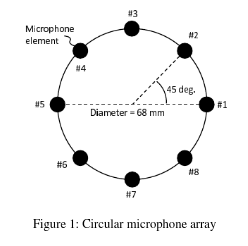

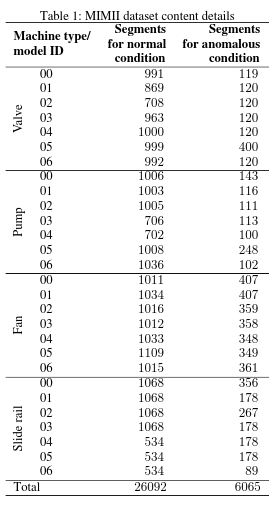

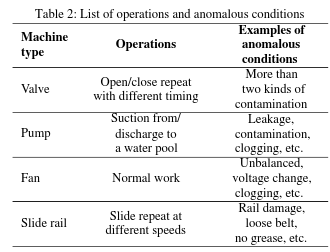

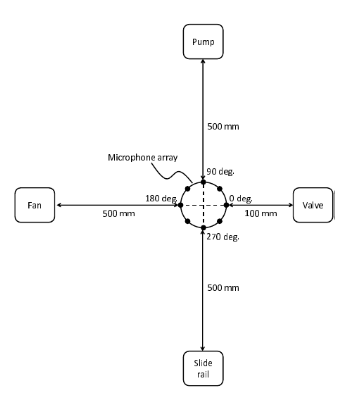

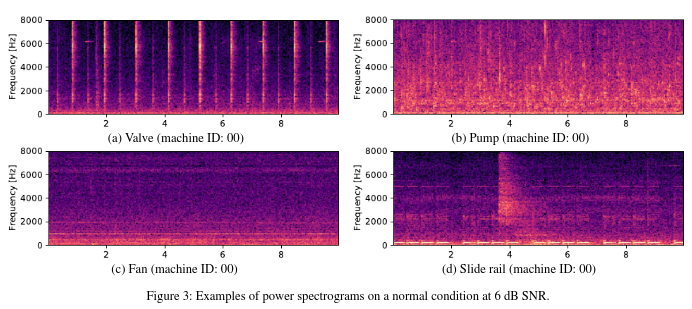

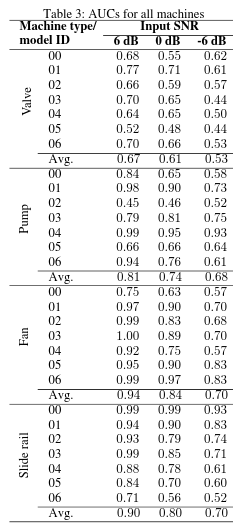

# Feature extraction function

In [22]:
def extract_features(file):

    # check if normal or abnormal
    if 'abnormal' in file:
        operation=1
    else:
        operation=0
    # loading the file, getting y and sr (sample rate)

    y, sr = librosa.load(file)

    # Getting S and phase

    S, phase = librosa.magphase(librosa.stft(y=y))

    # Features for the DataFrame
# chroma features have pitch which is probably not usefull
    chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr))

    chroma_cqt = np.mean(librosa.feature.chroma_cqt(y=y, sr=sr))

    chroma_cens = np.mean(librosa.feature.chroma_cens(y=y, sr=sr))
# to do
    melspectrogram = np.mean(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_min = np.min(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_max = np.max(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
    melspectrogram_sum = librosa.feature.melspectrogram(y=y, sr=sr, S=S).sum()
    melspectrogram_corr= np.mean(np.corrcoef(librosa.feature.melspectrogram(y=y, sr=sr, S=S)))
    melspectrogram_std= np.std(librosa.feature.melspectrogram(y=y, sr=sr, S=S))
# to check This feature is one of the most important method to extract a feature of an audio signal and is 
#used majorly whenever working on audio signals. The mel frequency cepstral coefficients (MFCCs) of a signal 
#are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral 
#envelope.
    
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr))
#rms when plotted similarities with melspectorgram
#normal rms mean higher than abnormal?
    rms = np.mean(librosa.feature.rms(y=y, S=S))
#spectral centroid computes weighted mean of the frequencies in the sound
#plot is line on melspectogram
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr, S=S))
#Bandwidth(blue zone) is the difference between the upper and lower frequencies in a continuous band of frequencies
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr, S=S))
#needs further investigation, but makes continous data discrete in bins
    spectral_contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr, S=S))
#Spectral flatness (or tonality coefficient) is a measure to quantify how much noise-like a sound is, as opposed to
#being tone-like 1. A high spectral flatness (closer to 1.0) indicates the spectrum is similar to white noise. 
#It is often converted to decibel.
    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=y, S=S))
#The roll-off frequency is defined for each frame as the center frequency for a spectrogram bin such that at 
#least roll_percent (0.85 by default) of the energy of the spectrum in this frame is contained in this bin and 
#he bins below. This can be used to, e.g., approximate the maximum (or minimum) frequency by setting roll_percent 
#to a value close to 1 (or 0).
#rolloff with rolloff coefficient 0.01 seems to be the same for (ab)normal
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr, S=S))
#Get coefficients of fitting an nth-order polynomial to the columns of a spectrogram
    poly_features = np.mean(librosa.feature.poly_features(y=y, sr=sr, S=S))
#probably chroma
    tonnetz = np.mean(librosa.feature.tonnetz(y=y, sr=sr))
#normal has higher zero crossing rate?
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
#divide in frequency bands could give more information bout difference normal and abnormal (BPM)
    #tempo = librosa.beat.tempo(onset_envelope=oenv, sr=sr,
                       #    hop_length=hop_length)[0]
    # putting them into a dataframe
    y_harmonic, y_percussive = librosa.effects.hpss(y)
    return pd.DataFrame({ 'melspectrogram' : [melspectrogram],'melspectrogram_min':[melspectrogram_min],
                             'melspectrogram_max':[melspectrogram_max], 'melspectrogram_sum':[melspectrogram_sum],
                             'melspectrogram_corr':[melspectrogram_corr] ,'melspectrogram_std':[melspectrogram_std] ,
                             'mfcc' : [mfcc], 'rms' : [rms],
                            'spectral_centroid' : [spectral_centroid], 'spectral_bandwidth' : [spectral_bandwidth],
                            'spectral_contrast' : [spectral_contrast], 'spectral_flatness ' : [spectral_flatness],
                            'spectral_rolloff' : [spectral_rolloff], 
                            'zero_crossing_rate' : [zero_crossing_rate],"mean harm": np.mean(y_harmonic),
                            "mean perc": [np.mean(y_percussive)],"max harm":[np.max(y_harmonic)],"max perc": [np.max(y_percussive)],
                             "min harm":[np.min(y_harmonic)], "min perc":[np.min(y_percussive)], 'normal(0)/abnormal(1)':[operation]})

# .csv file creation for the features of a machine at certain dB level

In [23]:
import os
import sys
import time
def create_csv(machine, dB_level):
    # start measuring excecution time
    start_time = time.time()
    #create empty list that will be filled with pathnames
    #find paths normal wav files
    list_normal = []
    num=[0,2,4,6]
    for i in num:
        directory_normal = f"/home/regis/Desktop/Sound Project/files/{machine}/{dB_level}_dB_{machine}/{machine}/id_0{i}/normal/"
        for filename in os.listdir(directory_normal):
            file = f"{directory_normal}{filename}"
            list_normal.append(file)
    list_normal.sort()
    #find paths abnormal wav files
    list_abnormal = []
    num=[0,2,4,6]
    for i in num:
        directory_abnormal = f"/home/regis/Desktop/Sound Project/files/{machine}/{dB_level}_dB_{machine}/{machine}/id_0{i}/abnormal/"
        for filename in os.listdir(directory_abnormal):
            file = f"{directory_abnormal}{filename}"
            list_abnormal.append(file)
    list_abnormal.sort()
    #add normal to df
    for wav_file in list_normal:
        df = extract_features(wav_file)
        if wav_file == list_normal[0]:
            df.to_csv(f'Librosa_features_{machine}_{dB_level}.csv')
        else:
            df.to_csv(f'Librosa_features_{machine}_{dB_level}.csv', mode='a', header=False)
    #add abnormal to df
    for wav_file in list_abnormal:
        df = extract_features(wav_file)
        df.to_csv(f'Librosa_features_{machine}_{dB_level}.csv', mode='a', header=False) 
    print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
create_csv('slider','6')

# .csv files merging into one dataframe containing features for certain machine at all dB levels

In [24]:
def merge_pd(machine):
    # Opening the .csv files
    
    df_6dB=pd.read_csv(f'Librosa_features_{machine}_6dB.csv')
    df_0dB=pd.read_csv(f'Librosa_features_{machine}_0dB.csv')
    df_min6dB=pd.read_csv(f'Librosa_features_{machine}_-6dB.csv')
    
    # Dropping the 'Unnamed: 0' column
    
    df_6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_0dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    df_min6dB.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)
    
    # Add the number of dB to each column name for each .csv file

    df_6dB.columns = [str(col) + '_6dB' for col in df_6dB.columns]
    df_0dB.columns = [str(col) + '_0dB' for col in df_0dB.columns]
    df_min6dB.columns = [str(col) + '_-6dB' for col in df_min6dB.columns]
    
    # Merging the .csv files into one DataFrame
    
    data_frames = [df_6dB, df_0dB, df_min6dB]
    df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True,how='outer'), data_frames)
    
    df_merged.head()
    
    return df_merged

# Machine learning

## Metrics explenation

# Machine 1: Valve

In [25]:
valve = merge_pd('valve')

# Machine 2: Pump

# Machine 3: Fan

# Machine 4: Slide rail

# Machine learning on all machines combined